In [9]:
using Distributions, TimeIt, ProgressMeter, PyPlot, JLD
include("zz_structures_DuLuSuSe.jl")
include("mbsampler.jl")
include("polyagamma.jl");

#### Load data:

In [2]:
d, Nobs = 5_000, 7_000
X = sprandn(d, Nobs, 1e-2)
ξ_true = 3*sprandn(d, 1e-2)
ξ_true[1] = 3*randn()
y = [rand(Binomial(1, 1/(1+exp(-X[:,n]'ξ_true)))) for n in 1:Nobs];

#### Define prior:

In [3]:
σ02 = 1
prior = SS_prior(d, σ02);
# prior = gaussian_prior_nh(d, σ02);

#### Define model:

In [4]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior)
# root = find_root(my_model, rand(d));

#### Define minibatch sampler:

In [5]:
mb_size = 200
weights_het = spzeros(d, Nobs)
@showprogress for i in 1:d 
    nzind = X[i,:].nzind
    weights_het[i,nzind] = abs.(X[i,nzind])./sum(abs.(X[i,nzind]))
end

prob_het = 0.98
gs = Array{mbsampler}(d)
gs[1] = umbsampler(Nobs, mb_size)
@showprogress for i in 2:d 
    gs[i] = spwumbsampler(Nobs, mb_size, weights_het[i,:], prob_het)
end
gs_list = mbsampler_list(d,gs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


#### Define output scheduler:

In [6]:
A = eye(d)

opf = projopf(A, 1000, hyperparam_size(prior))
opt = maxa_opt(5*10^4)
outp = outputscheduler(opf,opt)
bb = linear_bound(my_model.ll, my_model.pr, gs_list)
mstate = zz_state(d)
update_bound(bb, my_ll, prior, gs_list, mstate);

#### Define mbsampler + block Gibbs sampler list:

In [7]:
adapt_speed = "by_var" 
L = 1
my_zz_sampler = zz_sampler(0, gs_list, bb, L, adapt_speed)
hyper_sampler = block_gibbs_sampler(1e4)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

#### Run sampler:

In [8]:
start = time()
ZZ_block_sample(my_model, outp, blocksampler, mstate)
print( round((time()-start)/60, 2), " mins")

10% attempts in 0.45 mins 
20% attempts in 0.92 mins 
30% attempts in 1.28 mins 
40% attempts in 1.6 mins 
50% attempts in 1.88 mins 
60% attempts in 2.15 mins 
70% attempts in 2.42 mins 
80% attempts in 2.72 mins 
90% attempts in 3.01 mins 
100% attempts in 3.3 mins 
3.3 mins

* Number of bounces:

In [12]:
zz_bounces = sum(mstate.n_bounces)
hyp_bounces = outp.opf.tcounter-zz_bounces
@printf("ZZ bounces: %i, hyper bounces: %i", zz_bounces, hyp_bounces)

ZZ bounces: 89332, hyper bounces: 5669

In [13]:
size(outp.opf.xi_skeleton,2)/outp.opt.max_attempts, outp.opf.bt_skeleton[end]

(0.0192, 0.0)

In [14]:
mstate.α;

#### Extract samples:

In [15]:
discard = 20_000
n_samples = 10^4
xi_samples_gzz = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             (outp.opf.bt_skeleton[end]-outp.opf.bt_skeleton[discard+1])/n_samples,
                             "linear")[:,1:end-1];
hyp_samples_gzz = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                              outp.opf.bt_skeleton[:,discard+1:end], 
                              (outp.opf.bt_skeleton[end]-outp.opf.bt_skeleton[discard+1])/n_samples,
                              "constant")[:,1:end-1];

LoadError: [91mBoundsError: attempt to access 10000×10001 Array{Float64,2} at index [Base.Slice(Base.OneTo(10000)), 10002][39m

#### Posterior coverage:

In [16]:
cover_gzz = zeros(d)
ci_gzz = zeros(d,2)
for i in 1:d 
    ci_gzz[i,:] = percentile(xi_samples_gzz[i,:], [2.5, 97.5])
    cover_gzz[i] = (ci_gzz[i,1]<ξ_true[i])&(ξ_true[i]<ci_gzz[i,2])
end
print(100*mean(cover_gzz))

LoadError: [91mUndefVarError: xi_samples_gzz not defined[39m

In [17]:
post_mean_gzz = mean(xi_samples_gzz,2)
# sort(abs.(post_mean_gzz[ξ_true.nzind]), rev=true)
post_median_gzz = median(xi_samples_gzz,2);
# post_median_gzz[ξ_true.nzind]

LoadError: [91mUndefVarError: xi_samples_gzz not defined[39m

In [18]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior mean")
plot(sort(vec(abs.(post_median_gzz)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Gibbs zig-zag sampler")
legend(ncol=3);

LoadError: [91mUndefVarError: post_mean_gzz not defined[39m

### Polya Gamma data augmentation:

In [ ]:
xi_samples_pg, hyp_samples_pg = PG(my_model, rand(d), 2*10^1)
post_mean_pg = mean(xi_samples_pg,2)
post_median_pg = median(xi_samples_pg,2);

In [ ]:
fig = figure(figsize=(12,3))
plot(sort(abs.(ξ_true.nzval), rev=true), "o-", markersize=3, label="true signal")
plot(sort(vec(abs.(post_mean_pg)), rev=true)[1:50], "o-", markersize=3, label="posterior mean")
plot(sort(vec(abs.(post_median_pg)), rev=true)[1:50], "o-", markersize=3, label="posterior median")
grid(true)
title("Polya-Gamma data augmentation")
legend(ncol=3);

#### Plot ACFs:

In [22]:
maxlag = 500
acfs_xi_gzz = zeros(d, maxlag)
acfs_hyp_gzz = zeros(size(hyp_samples_gzz,1), maxlag)

@showprogress for i in 1:d 
    acfs_xi_gzz[i,:] = acf(xi_samples_gzz[i,:], maxlag)
end
@showprogress for i in 1:size(hyp_samples_gzz,1)
    acfs_hyp_gzz[i,:] = acf(hyp_samples_gzz[i,:], maxlag)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


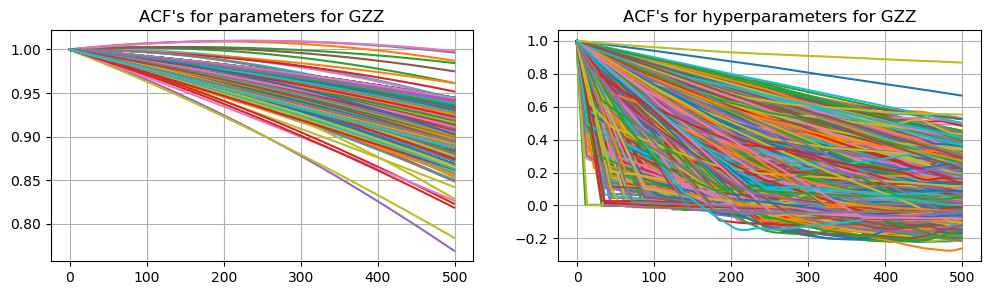

In [23]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
for i in 1:d 
    plot(acfs_xi_gzz[i,:])
end
grid(true)
title("ACF's for parameters for GZZ")

subplot(122)
for i in 1:size(hyp_samples_gzz,1) 
    plot(acfs_hyp_gzz[i,:])
end
grid(true)
title("ACF's for hyperparameters for GZZ");

In [24]:
maxlag = 500
acfs_xi_pg = zeros(d, maxlag)
acfs_hyp_pg = zeros(size(hyp_samples_pg,1), maxlag)

@showprogress for i in 1:d 
    acfs_xi_pg[i,:] = acf(xi_samples_pg[i,:], maxlag)
end
@showprogress for i in 1:size(hyp_samples_gzz,1)
    acfs_hyp_pg[i,:] = acf(hyp_samples_pg[i,:], maxlag)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


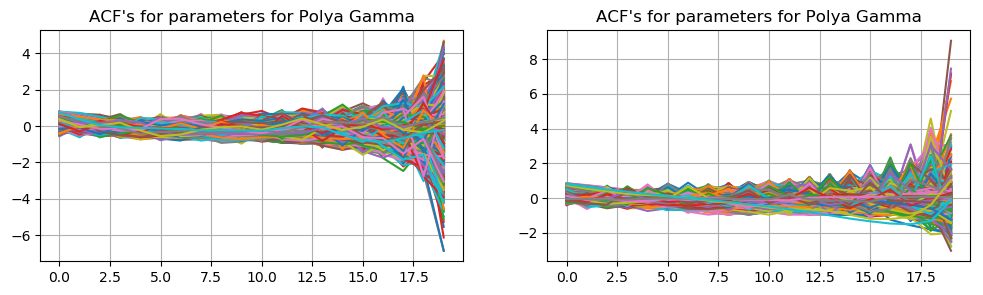

In [25]:
fig = figure("pyplot_subplot_mixed", figsize=(12,3))
subplot(121)
for i in 1:d 
    plot(acfs_xi_pg[i,:])
end
grid(true)
title("ACF's for parameters for Polya Gamma")

subplot(122)
for i in 1:size(hyp_samples_pg,1) 
    plot(acfs_hyp_pg[i,:])
end
grid(true)
title("ACF's for parameters for Polya Gamma");